In [1]:
#make sure about the cuda version
import numpy as np
import webdataset as wds
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms 
import os
import random
from itertools import islice
import matplotlib.pyplot as plt
import pickle
PATH_TO_DATA = "/glade/scratch/yiwenz/TransferLearningData/rand_shard_data/" 

In [2]:
image_normalize = transforms.Normalize(
                  mean=[0.17960437768666657, 0.14584139607643212, 0.10744440357398845, 0.2583671063835548],
                  std=[0.059635202669355195, 0.04059554002618016, 0.03371736326989986, 0.06295501902505744]
)

forcing_normalize = transforms.Normalize(
                  mean=[444.9605606256559, 991.7980623653417, 0.00039606951184754176, 96111.04161525163, 0.006652783216819315, 314.3219695851273, 2.82168247768119],
                  std=[5.5216369223813535, 12.951212256256913, 0.0002824274832735609, 975.3770569179914, 0.00012386107613000674, 0.6004463118907452, 0.34279194598853185]
)

forcing_mean = torch.from_numpy(np.array([444.9605606256559, 991.7980623653417, 0.00039606951184754176, 96111.04161525163, 0.006652783216819315, 314.3219695851273, 2.82168247768119]))
forcing_std = torch.from_numpy(np.array([5.5216369223813535, 12.951212256256913, 0.0002824274832735609, 975.3770569179914, 0.00012386107613000674, 0.6004463118907452, 0.34279194598853185]))

lst_mean = torch.from_numpy(np.array([312.8291360088677]))
lst_std = torch.from_numpy(np.array([11.376636496297289]))

In [3]:
def create_train_test(path_to_data, train_perc, test_perc):
    files = []
    for dirpath, dirnames, filenames in os.walk(path_to_data):
        files.extend(filenames)
    
    saturated = files[:-1]
    unsaturated = files[-1]
    
    dataset = wds.WebDataset(path_to_data + "/" + unsaturated)
    counter = 0
    for data in dataset:
        counter += 1
    
    total_files = counter + len(saturated) * 10000
    training_data = total_files * train_perc //10000
    test_data_files = total_files * test_perc //10000

    training_data = random.sample(files, int(training_data))
    test_data = [file for file in files if file not in training_data]
    test_data = random.sample(test_data, int(test_data_files))
    # Get sample sizes of train and test data
    training_samples = 0
    testing_samples = 0
    
    for path in training_data:
        if path in saturated:
            training_samples += 10000
        elif path in unsaturated:
            training_samples += counter
            
    for path in test_data:
        if path in saturated:
            testing_samples += 10000
        elif path in unsaturated:
            testing_samples += counter
            
            
    # Convert to filename lists 
    training_filepath = []
    for dat in training_data:
        print(dat[6:12])
        training_filepath.append(dat[6:12])
    training_path = path_to_data + "shard-" + "{" + ",".join(training_filepath) + "}" + ".tar"
    
    testing_filepath = []
    for dat in test_data:
        testing_filepath.append(dat[6:12])
    testing_path = path_to_data + "shard-{" + ",".join(testing_filepath) +"}.tar"
    train_data = wds.WebDataset(training_path).shuffle(30000, initial=30000).decode("rgb").rename(image="image.pyd", forcing="forcing.pyd", lst = "lst.pyd").to_tuple("image", "forcing", "lst")
    test_data = wds.WebDataset(testing_path).decode("rgb").shuffle(30000, initial=30000).rename(image="image.pyd", forcing="forcing.pyd", lst = "lst.pyd").to_tuple("image", "forcing", "lst")
            
    return (train_data, training_samples), (test_data, testing_samples)
    
(train_data, training_samples_len), (test_data, testing_samples_len) = create_train_test(PATH_TO_DATA, 0.85, 0.1)

000141
000100
000041
000169
000133
000045
000083
000125
000174
000094
000126
000064
000116
000016
000065
000144
000124
000114
000052
000068
000081
000120
000186
000168
000115
000012
000025
000188
000080
000073
000147
000019
000105
000138
000048
000200
000159
000142
000058
000097
000003
000150
000196
000096
000056
000088
000178
000013
000171
000153
000037
000061
000086
000164
000190
000040
000028
000198
000039
000132
000049
000127
000104
000118
000018
000075
000000
000010
000091
000117
000140
000070
000089
000177
000184
000087
000156
000172
000165
000193
000110
000076
000082
000139
000160
000191
000050
000069
000034
000122
000145
000158
000055
000026
000155
000166
000006
000077
000170
000197
000195
000036
000022
000175
000199
000137
000057
000146
000134
000015
000004
000109
000148
000035
000099
000095
000157
000002
000106
000067
000060
000047
000074
000119
000023
000066
000059
000079
000063
000176
000062
000108
000011
000021
000201
000204
000131
000032
000009
000112
000084
000042
000031

In [17]:
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor

def process_data(image, forcing, lst):
    image, forcing, lst = image.to(torch.float32).to(DEVICE), forcing.to(DEVICE), lst.to(DEVICE)
    # Image Transformations
    image = torch.clip(image, min=0, max=1)
    image = image_normalize(image)
    # Forcing Transformation
    forcing = torch.div(torch.sub(forcing, forcing_mean), forcing_std).to(torch.float32)
    # LST Transformation
#     lst = torch.div(torch.sub(lst, lst_mean), lst_std).to(torch.float32).view(-1, 1)
    lst = lst.view(-1, 1).to(torch.float32)
    return image, forcing, lst


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.leaky_relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.leaky_relu(out)

        return out

class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers: List[int],
        in_channel=4,
        forcing_shape = 7,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.flatten_shape = None
        
        self.conv1 = nn.Conv2d(in_channel, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool1 = nn.AvgPool2d(2)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
#        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
#        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool2 = nn.AdaptiveAvgPool2d((1,1))
        
#        self.fc0 = nn.Linear(512, out_features=64)
        self.fc1 = nn.Linear(128+forcing_shape, out_features=1)
#        self.fc2 = nn.Linear(in_features=2048, out_features=1)
#        self.fc3 = nn.Linear(in_features=64, out_features=1)    

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = nn.ModuleList([])
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x: Tensor, forcing) -> Tensor:
        # See note [TorchScript super()]
#        x = self.conv0(x)
#        x = x.permute([0,3,1,2])
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.avgpool1(x)

        x = self.layer1(x)
        x = self.layer2(x)
#        x = self.layer3(x)
#        x = self.layer4(x)
        x = self.avgpool2(x)
        x = torch.flatten(x, 1)
#        x = self.fc0(x)
#        x = F.leaky_relu(x)
        x = torch.cat((x, forcing), dim=1)
        x = self.fc1(x)
#        x = F.leaky_relu(x)
#        x = self.fc2(x)
#        x = F.leaky_relu(x)
#        x = self.fc3(x)

        return x

def resnet_simplified():
    return ResNet(BasicBlock,[3,3,0,0])

In [ ]:
# from collections import OrderedDict
# url_resnet18= "https://download.pytorch.org/models/resnet18-5c106cde.pth"
# def load_pretrained_weights(model,url,mode):
#     if mode == 'online':
#         """ Loads pretrained weights, and downloads if loading for the first time. """
#         state_dict = torch.utils.model_zoo.load_url(url)
#         state_dict.pop("fc.weight")
#         state_dict.pop("fc.bias")
#         weight = state_dict['conv1.weight'].clone()
#         state_dict.pop("conv1.weight")
#         model.load_state_dict(state_dict, strict=False)
#         model.conv1.weight.data[:, :3] = weight
#         model.conv1.weight.data[:, 3] = torch.mean(model.conv1.weight.data[:, :3],dim=1)
#     elif mode == 'local':
#         new_state_dict = OrderedDict()
#         state_dict = torch.load('resnet_10.pt')
#         for k, v in state_dict.items():
#             name = k[7:] # remove `module.`
#             new_state_dict[name] = v
#         # load params
#         model.load_state_dict(new_state_dict)
# #    print(res.missing_keys)
# #    assert set(res.missing_keys) == {"fc.weight", "fc.bias"}, "issue loading pretrained weights"
#     print(f"Loaded pretrained weights.")

In [18]:
model=resnet_simplified()
#load_pretrained_weights(model,url_resnet18,mode='local')

In [17]:
# #Freeze imagenet parameters
# for name, param in model.named_parameters():
#     if param.requires_grad and 'layer' in name:
# #        print(name)
#         param.requires_grad = False
# model.bn1.weight.requires_grad = False
# model.bn1.bias.requires_grad = False

In [ ]:
from tqdm import tqdm

EPOCHS = 100
LEARNING_RATE = 5e-4
DECAY_RATE = 0.99
DEVICE = "cuda"
BATCH_SIZE = 1024

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=8)

model = model.to(DEVICE)
model = torch.nn.DataParallel(model)
loss_fn = nn.SmoothL1Loss()
#loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.95)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=DECAY_RATE)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")

test_loss = []
train_loss = []

lst_mean = lst_mean.to(DEVICE)
lst_std = lst_std.to(DEVICE)
forcing_mean = forcing_mean.to(DEVICE)
forcing_std = forcing_std.to(DEVICE)

min_test_loss = np.inf 
for epoch in range(EPOCHS):
    print("****** EPOCH: [{}/{}] LR: {} ******".format(epoch, EPOCHS, round(optimizer.param_groups[0]['lr'], 6)))
    running_train_loss = 0
    train_n_iter = 0
    running_test_loss = 0
    test_n_iter = 0
    
    # model.train()
    loop_train = tqdm(train_loader, total=(training_samples_len//BATCH_SIZE) + 1, leave=True)
    for idx, (image, forcing, lst) in enumerate(loop_train):
        image, forcing, lst = process_data(image, forcing, lst)
        optimizer.zero_grad()
        forward_out = model.forward(image, forcing)
        loss = loss_fn(forward_out, lst)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        train_n_iter += 1
        loop_train.set_postfix(train_loss=loss.item())
        
    loop_test = tqdm(test_loader, total=(testing_samples_len//BATCH_SIZE) + 1, leave=False)
    
    # model.eval()
    with torch.no_grad():
        for idx, (image, forcing, lst) in enumerate(loop_test):
            image, forcing, lst = process_data(image, forcing, lst)
            pred = model.forward(image, forcing)
            testloss = loss_fn(pred, lst)
            running_test_loss += testloss.item()
            test_n_iter += 1
            loop_test.set_postfix(test_loss=testloss.item())

    avg_train_loss = running_train_loss/train_n_iter
    train_loss.append(avg_train_loss)
    avg_test_loss = running_test_loss/test_n_iter
    test_loss.append(avg_test_loss)
    
    scheduler.step()
    scheduler2.step(avg_test_loss)
#     if avg_test_loss < min_test_loss:
#         print("Saving Model")
#         min_test_loss = avg_test_loss
#         torch.save(model.state_dict(), "resnet_11.pt")
    
#     print("Saving Loss")
#     file_name = "train_loss_11.pkl"
#     open_file = open(file_name, "wb")
#     pickle.dump(train_loss, open_file)
#     open_file.close()
#     file_name = "test_loss_11.pkl"
#     open_file = open(file_name, "wb")
#     pickle.dump(test_loss, open_file)
#     open_file.close()
    print("------ Train Loss: {}, Test Loss: {} ------".format(avg_train_loss, avg_test_loss))

  0%|          | 0/1719 [00:00<?, ?it/s]

****** EPOCH: [0/100] LR: 0.0005 ******


1720it [01:46, 16.17it/s, train_loss=5.73]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 97.12796076619348, Test Loss: 5.93673220872879 ------
****** EPOCH: [1/100] LR: 0.000495 ******


1720it [01:43, 16.67it/s, train_loss=5]                             
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 5.327743521679279, Test Loss: 4.969243290424347 ------
****** EPOCH: [2/100] LR: 0.00049 ******


1720it [01:43, 16.67it/s, train_loss=4.81]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 4.844923647614412, Test Loss: 4.704987785816193 ------
****** EPOCH: [3/100] LR: 0.000485 ******


1720it [01:44, 16.39it/s, train_loss=4.7]                           
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 4.608911149446354, Test Loss: 4.499098998308182 ------
****** EPOCH: [4/100] LR: 0.00048 ******


1720it [01:44, 16.43it/s, train_loss=4.69]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 4.460321586353834, Test Loss: 4.458783519268036 ------
****** EPOCH: [5/100] LR: 0.000475 ******


1720it [01:46, 16.19it/s, train_loss=4.5]                           
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 4.356376839515775, Test Loss: 4.372434899806977 ------
****** EPOCH: [6/100] LR: 0.000471 ******


1720it [01:44, 16.46it/s, train_loss=4.37]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 4.282506649438725, Test Loss: 4.3074155926704405 ------
****** EPOCH: [7/100] LR: 0.000466 ******


1720it [01:56, 14.79it/s, train_loss=4.33]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 4.223782131283782, Test Loss: 4.239602183103561 ------
****** EPOCH: [8/100] LR: 0.000461 ******


1720it [01:45, 16.37it/s, train_loss=4.29]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 4.176427609837332, Test Loss: 4.21449528336525 ------
****** EPOCH: [9/100] LR: 0.000457 ******


1720it [01:44, 16.53it/s, train_loss=4.18]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 4.134367743203806, Test Loss: 4.189360558986664 ------
****** EPOCH: [10/100] LR: 0.000452 ******


1720it [01:50, 15.51it/s, train_loss=4.21]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 4.1033315001532085, Test Loss: 4.184059134721756 ------
****** EPOCH: [11/100] LR: 0.000448 ******


1720it [01:49, 15.78it/s, train_loss=4.17]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 4.072650832353636, Test Loss: 4.136562192440033 ------
****** EPOCH: [12/100] LR: 0.000443 ******


1720it [01:44, 16.44it/s, train_loss=4.14]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 4.048711363243502, Test Loss: 4.131272475719452 ------
****** EPOCH: [13/100] LR: 0.000439 ******


1720it [01:44, 16.50it/s, train_loss=4.16]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 4.025700560558674, Test Loss: 4.087508246898651 ------
****** EPOCH: [14/100] LR: 0.000434 ******


1720it [01:44, 16.47it/s, train_loss=4.05]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 4.004413953492808, Test Loss: 4.10721269607544 ------
****** EPOCH: [15/100] LR: 0.00043 ******


1720it [01:44, 16.42it/s, train_loss=4.12]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 3.9861567095268606, Test Loss: 4.1036288189888 ------
****** EPOCH: [16/100] LR: 0.000426 ******


1720it [01:45, 16.37it/s, train_loss=4.09]                          
  0%|          | 0/1719 [00:00<?, ?it/s]                         

------ Train Loss: 3.9721432335154954, Test Loss: 4.066394786834717 ------
****** EPOCH: [17/100] LR: 0.000421 ******


 65%|██████▍   | 1111/1719 [01:11<00:34, 17.70it/s, train_loss=3.86]

# Igonre stuff below

In [8]:
file_name = "train_loss_11.pkl"
open_file = open(file_name, "rb")
train_loaded = pickle.load(open_file)
open_file.close()
file_name = "test_loss_11.pkl"
open_file = open(file_name, "rb")
test_loaded = pickle.load(open_file)
open_file.close()

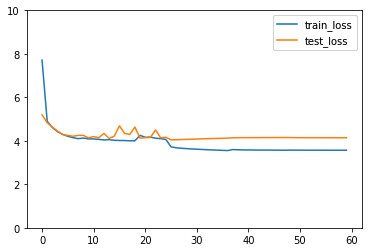

In [9]:
fig, ax = plt.subplots()
line1, = ax.plot(train_loaded, label="train_loss")
line2, = ax.plot(test_loaded, label="test_loss")
ax.set_ylim([0, 10])
# Create a legend for the first line.
first_legend = ax.legend(loc='upper right')
# Add the legend manually to the Axes.
ax.add_artist(first_legend)
plt.show()

In [25]:
import pickle
file_name = "train_loss.pkl"

open_file = open(file_name, "wb")
pickle.dump(train_loss, open_file)
open_file.close()

file_name = "test_loss.pkl"

open_file = open(file_name, "wb")
pickle.dump(test_loss, open_file)
open_file.close()

In [20]:
train_4=train_loaded+train_loss
test_4=test_loaded+test_loss

In [24]:
file_name = "train_loss_4.pkl"
open_file = open(file_name, "wb")
pickle.dump(train_4, open_file)
open_file.close()
file_name = "test_loss_4.pkl"
open_file = open(file_name, "wb")
pickle.dump(test_4, open_file)
open_file.close()